In [1]:
# Restart the kernel
import os
current_dir ='../../'
os.chdir(current_dir)

In [2]:
from src.codes.basic import *
from src.codes.utils import *
from src.codes.base_classes import Base_class_fem_heat_conduction
from src.codes.reductor.rom_class import FEM_solver_rom_ecsw
from src.codes.algorithms.ecsw import ecsw_red

### class for data (geometry, material property, mesh)

In [3]:
nref= [3,3,3]
L = [10.,12.,14.]

mat_layout = np.zeros((4,4,4),dtype=int)
src_layout = np.zeros((4,4,4),dtype=int)

# src_layout[0,0,0] = 1
# src_layout[1,1,1] = 1
# src_layout[2,2,2] = 1
# src_layout[3,3,3] = 1

In [4]:
fdict = {}

cond_list = []
cond_list.append( lambda T,mu: mu*T + 100. + 0.*T )
fdict["cond"] = cond_list

dcond_list = []
dcond_list.append( lambda T,mu: mu + 0. + 0.*T )
fdict["dcond"] = dcond_list

qext_list = []
qext_list.append( lambda T,mu: 0.0+100.0 + 0.*T )
fdict["qext"] = qext_list

# qext_list = []
# qext_list.append(lambda T,mu: mu + 0.*T)
# qext_list.append(lambda T,mu: 2.0*mu + 0.*T)
# fdict["qext"] = qext_list

In [5]:
bc = {}
bc['x_min']={'type':'dirichlet','value':0.}
bc['x_max']={'type':'dirichlet','value':0.}
bc['y_min']={'type':'dirichlet','value':0.}
bc['y_max']={'type':'dirichlet','value':0.}
bc['z_min']={'type':'dirichlet','value':0.}
bc['z_max']={'type':'dirichlet','value':0.}

In [6]:
class probdata:
    
    def __init__(self, bc, cond_layout, qext_layout, fdict, nref, L, mu, pb_dim=3):
        
        self.dim_ = pb_dim
        # refine the mesh and update material and source layouts
        repeats = np.asarray(nref, dtype=int)
        self.cell2mat_layout = self.repeat_array(mat_layout,repeats)
        self.cell2src_layout = self.repeat_array(src_layout,repeats)
        
        ## change this mapping if needed.
        
        self.fdict = fdict
        
        # mesh data
        # cells
        self.ncells = [None] * pb_dim
        self.npts = [None] * pb_dim
        self.deltas = [None] * pb_dim
        self.xi=[]
        for i in range(pb_dim):
            self.ncells[i] = self.cell2mat_layout.shape[i]
            self.npts[i] = self.ncells[i]+1
            self.xi.append(np.linspace(0,L[i],self.npts[i]))
            self.deltas[i] = L[i]/self.ncells[i]
    
        self.n_verts = np.prod(np.array(self.npts))
                
        # Create nodal connectivity for the continuous Finite Element Method (cFEM)
        self.connectivity()
                
        # Store parameter value
        self.mu = mu
        
        # Store the dirichlet nodes if any
        handle_boundary_conditions(self, bc)
        
        # Determining the global equation numbers based on dirichlet nodes and storing in class
        get_glob_node_equation_id(self, self.dir_nodes)

        # Get global node numbers and equation IDs for the current element
        self.glob_node_eqnId = []
        self.glob_node_nonzero_eqnId = []
        self.local_node_nonzero_eqnId = []
        self.Le = []
        self.global_indices = []
        self.local_indices = []

        for i in range(self.n_cells):
            get_element_global_nodes_and_nonzero_eqnId(self, i, self.node_eqnId)

    
              
    def repeat_array(self, arr,repeats):
        for dim,n in enumerate(repeats):
            arr = np.repeat(arr,n,axis=dim)
        return arr     
    
    
    def connectivity(self):
        """
        Define nodal connectivity for each cell in the mesh.
        """

        # Initialize the connectivity array
        self.n_cells = np.prod(np.array(self.ncells))
        self.gn = np.zeros((self.n_cells,2**self.dim_),dtype=int)

        # # compute node ID from (i,j) cell identifiers
        # def node(*args):
        #     index = 0
        #     multiplier = 1
        #     for i, n in enumerate(args):
        #         index += n * multiplier
        #         if i < len(self.npts) - 1:
        #             multiplier *= self.npts[i]
        #     return index
        
        node = lambda i,j,k: i+j*self.npts[0]+k*self.npts[0]*self.npts[1]
        # Loop over all cells to define their nodal connectivity
        iel = 0
        for k in range(self.ncells[2]):
            for j in range(self.ncells[1]):
                for i in range(self.ncells[0]):
                    # counter-clockwise
                    self.gn[iel,0] = node(i  ,j  ,k  )
                    self.gn[iel,1] = node(i+1,j  ,k  )
                    self.gn[iel,2] = node(i+1,j+1,k  )
                    self.gn[iel,3] = node(i  ,j+1,k  )
                    self.gn[iel,4] = node(i  ,j  ,k+1)
                    self.gn[iel,5] = node(i+1,j  ,k+1)
                    self.gn[iel,6] = node(i+1,j+1,k+1)
                    self.gn[iel,7] = node(i  ,j+1,k+1)
                    iel += 1
  

### Simulate FOS

In [7]:
random.seed(25)
params = np.r_[1.:4.0:0.01]
quad_deg = 3
N_snap = 15 # Training Snapshots
NL_solutions = []
param_list = []
K_mus = []
q_mus = []




 Snap 0 



initial residual = 18117.552677045067 

iter 0, NL residual=533.9782187764824, delta=0.5697469128754653
iter 1, NL residual=0.4834584379398597, delta=0.0016675880758734644
iter 2, NL residual=3.7614567642077317e-07, delta=1.3735956903112144e-06
Convergence !!!


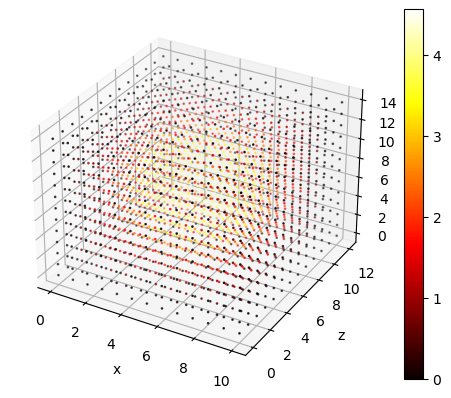




 Snap 1 



initial residual = 18288.267332881194 

iter 0, NL residual=645.9681917378493, delta=0.5258757410483998
iter 1, NL residual=0.8607385206306576, delta=0.001998499189011799
iter 2, NL residual=1.4522230751466062e-06, delta=2.4066851166497225e-06
Convergence !!!


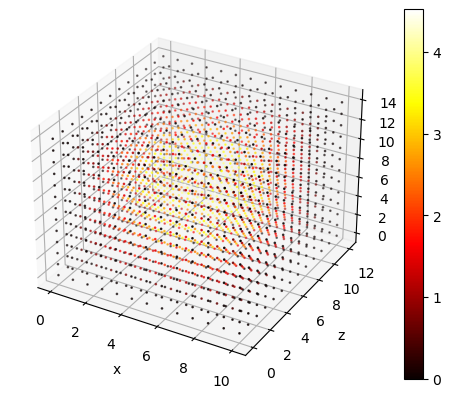




 Snap 2 



initial residual = 18600.766504046573 

iter 0, NL residual=844.2156209013255, delta=0.4493618841156839
iter 1, NL residual=1.9384070759347636, delta=0.0025318222252974257
iter 2, NL residual=9.73960266898583e-06, delta=5.2544066205114045e-06
Convergence !!!


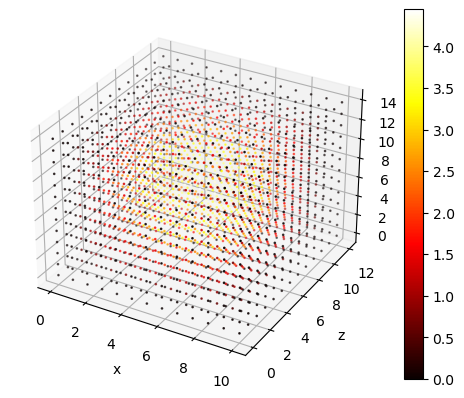




 Snap 3 



initial residual = 17798.055313415505 

iter 0, NL residual=316.71583003352015, delta=0.6561249039239331
iter 1, NL residual=0.09965461030146461, delta=0.0010417137341543934
iter 2, NL residual=9.351537500071055e-09, delta=2.9133191695019417e-07
Convergence !!!


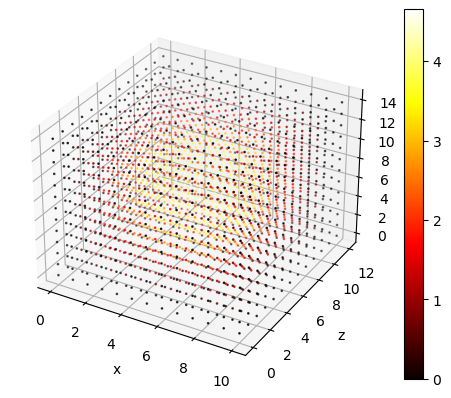




 Snap 4 



initial residual = 18193.823207306414 

iter 0, NL residual=584.3492061615696, delta=0.5499579885604017
iter 1, NL residual=0.6352311864892305, delta=0.0018203479482646419
iter 2, NL residual=7.128377280614371e-07, delta=1.7920820055787548e-06
Convergence !!!


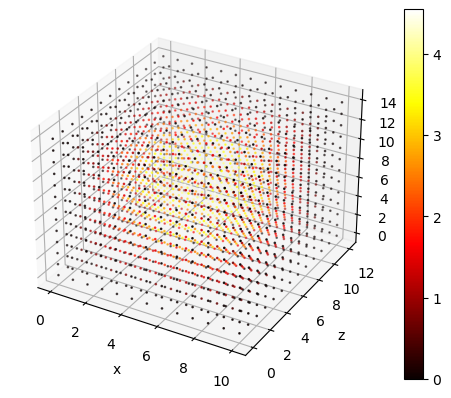




 Snap 5 



initial residual = 17783.537120764522 

iter 0, NL residual=306.5916195945243, delta=0.6601893786462559
iter 1, NL residual=0.09034512145985259, delta=0.0010120215720621222
iter 2, NL residual=7.435679210499309e-09, delta=2.6444940120450214e-07
Convergence !!!


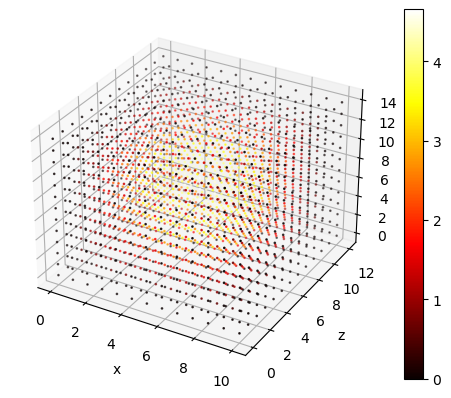




 Snap 6 



initial residual = 18288.267332881194 

iter 0, NL residual=645.9681917378493, delta=0.5258757410483998
iter 1, NL residual=0.8607385206306576, delta=0.001998499189011799
iter 2, NL residual=1.4522230751466062e-06, delta=2.4066851166497225e-06
Convergence !!!


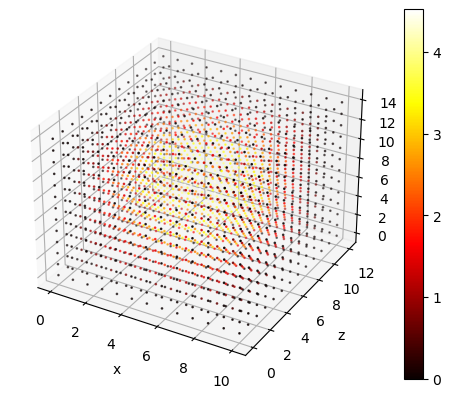




 Snap 7 



initial residual = 18771.61827851778 

iter 0, NL residual=949.1655057206987, delta=0.4094734080267834
iter 1, NL residual=2.7662278113019036, delta=0.0028078426363524907
iter 2, NL residual=2.2436349084964118e-05, delta=7.364409292441698e-06
iter 3, NL residual=1.0199582960630771e-11, delta=1.1915620180343032e-10
Convergence !!!


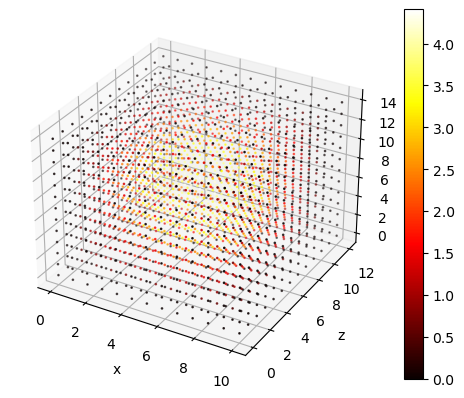




 Snap 8 



initial residual = 18509.90706023723 

iter 0, NL residual=787.4371656493331, delta=0.4711220817290562
iter 1, NL residual=1.5692626021337823, delta=0.0023662950100068465
iter 2, NL residual=5.9341315484264025e-06, delta=4.2933712580403645e-06
Convergence !!!


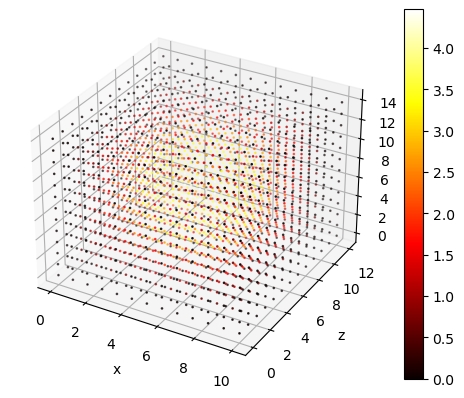




 Snap 9 



initial residual = 17899.69354182025 

iter 0, NL residual=386.9646732844921, delta=0.6280177055766263
iter 1, NL residual=0.18251291279116122, delta=0.0012379822617973127
iter 2, NL residual=3.849506198021581e-08, delta=5.288330070566306e-07
Convergence !!!


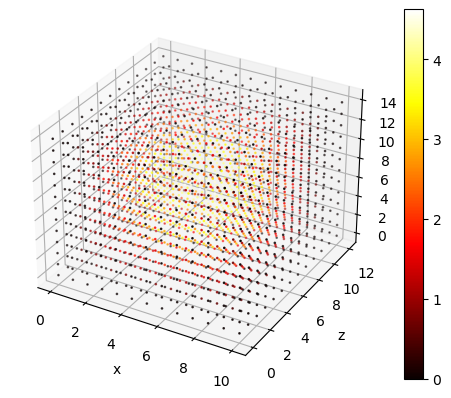




 Snap 10 



initial residual = 17950.519729505824 

iter 0, NL residual=421.6896126462212, delta=0.6141860320188067
iter 1, NL residual=0.2366555721480079, delta=0.0013281191160809378
iter 2, NL residual=7.068332619550028e-08, delta=6.826274871884853e-07
Convergence !!!


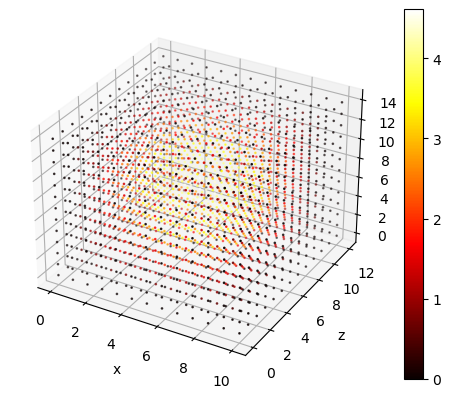




 Snap 11 



initial residual = 18789.79672548325 

iter 0, NL residual=960.1966340809689, delta=0.4053062862488349
iter 1, NL residual=2.864961836761371, delta=0.002834262767953909
iter 2, NL residual=2.4361625068702574e-05, delta=7.612280562251588e-06
iter 3, NL residual=1.0180507940014421e-11, delta=1.2915752846016243e-10
Convergence !!!


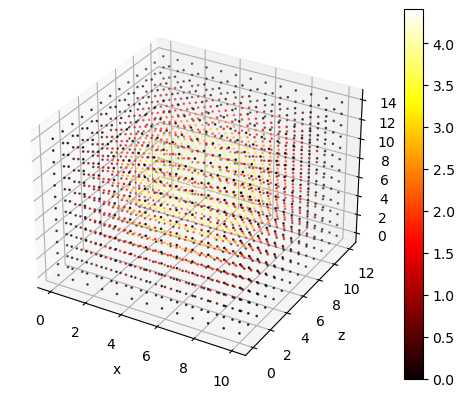




 Snap 12 



initial residual = 18084.868422779025 

iter 0, NL residual=512.2222336685539, delta=0.5783222287086509
iter 1, NL residual=0.42625093030648264, delta=0.0015999626190413606
iter 2, NL residual=2.8010512542719486e-07, delta=1.2146951333539937e-06
Convergence !!!


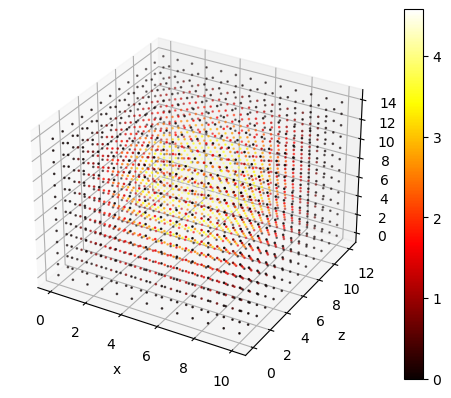




 Snap 13 



initial residual = 18673.463689258715 

iter 0, NL residual=889.1563802268982, delta=0.43222775168387995
iter 1, NL residual=2.268833375265241, delta=0.0026551951918203985
iter 2, NL residual=1.4090182752463841e-05, delta=6.103699092921879e-06
iter 3, NL residual=9.919319105922168e-12, delta=7.553475234051824e-11
Convergence !!!


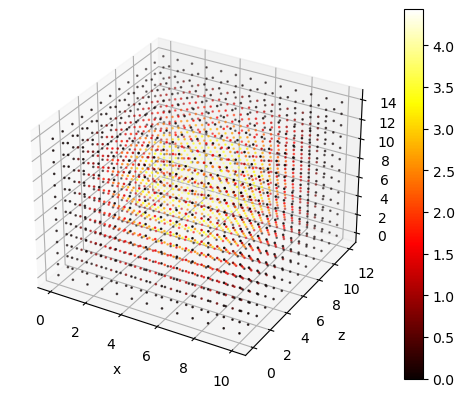




 Snap 14 



initial residual = 18306.43141530489 

iter 0, NL residual=657.7254602079772, delta=0.5212965998998546
iter 1, NL residual=0.9091122594432312, delta=0.002031233365694381
iter 2, NL residual=1.6506987671216231e-06, delta=2.5375237500045293e-06
Convergence !!!


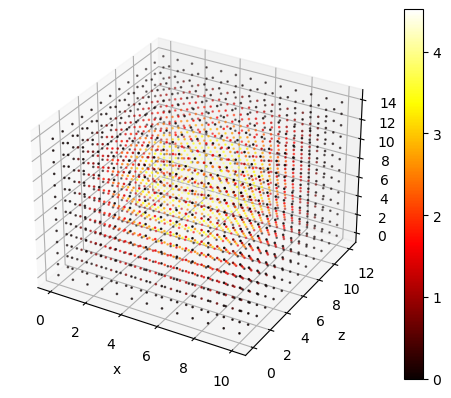

In [9]:
for i in range(N_snap):
    print(f"\n\n\n Snap {i} \n\n\n")
    param = random.choice(params) # Choose from parameter list
    param_list.append(param)
    
    if i==0:
        d = probdata(bc, mat_layout, src_layout, fdict, nref, L, param, pb_dim=3)
        FOS = Base_class_fem_heat_conduction(d,quad_deg)
    else:
        FOS.mu = param
    T_init = np.zeros(d.n_verts) + 4.0
    NL_solution_p, Ke, rhs_e, mask = solve_fos(FOS, T_init)
    NL_solutions.append(NL_solution_p.flatten())
    K_mus.append(Ke)
    q_mus.append(rhs_e)
    plot3D(d.xi[0], d.xi[1], d.xi[2], NL_solution_p, hmap=True)

In [10]:
NLS = np.asarray(NL_solutions)
np.shape(NLS)

(16, 2197)


### ECSW Hyper-reduction
#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

In [14]:
n_sel = 4
U, S, Vt = np.linalg.svd(np.transpose(NLS), full_matrices=False)
V_sel = U[:, :n_sel]
P_sel = V_sel[mask,:]@np.transpose(V_sel[mask,:])

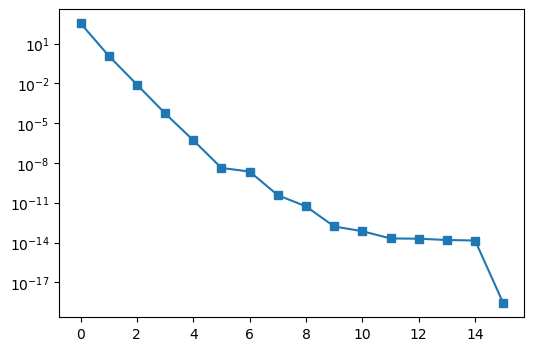

In [15]:
plt.figure(figsize = (6,4))
plt.semilogy(S,'s-')
plt.show()

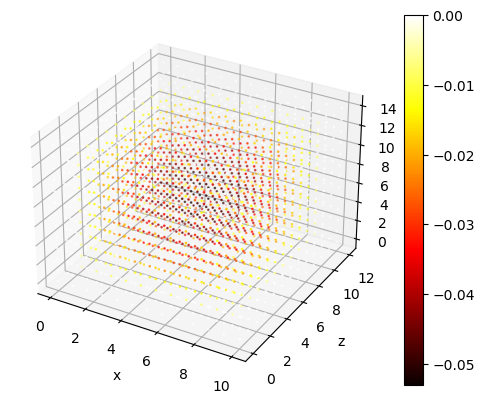

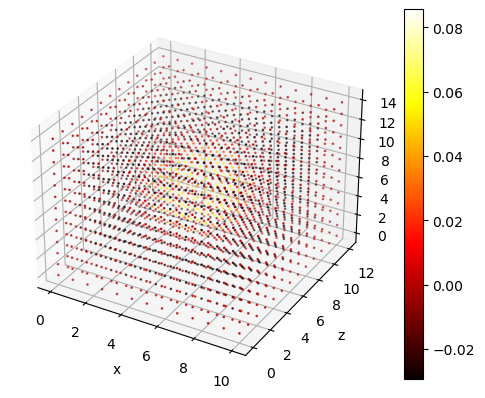

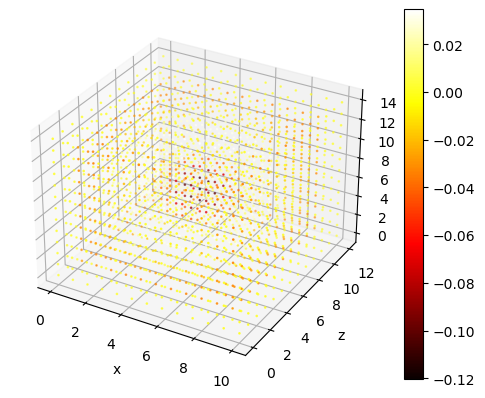

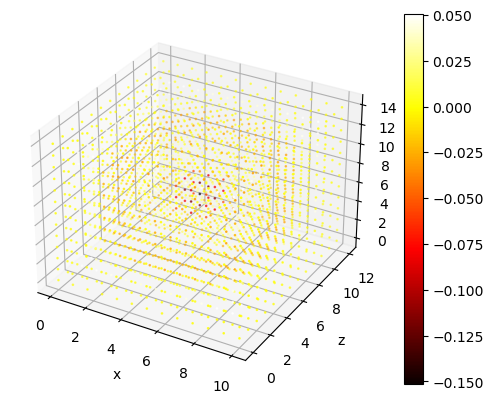

In [16]:
for i in range(n_sel):
    plot3D(d.xi[0],d.xi[1],d.xi[2],V_sel[:,i],hmap=True)

 
#### ECSW

In [22]:
tic_h_setup_b = time.time()
tol = 1e-9
xi, residual = ecsw_red(d, V_sel, d.Le, K_mus, q_mus, n_sel, N_snap, mask,NL_solutions,tol=tol)
toc_h_setup_b = time.time()

In [23]:
print(f"this is the residual from fnnls: {residual}")

this is the residual from fnnls: 2.562919840407684e-05


In [24]:
colors = ['red' if value > 0 else 'blue' for value in xi]
sizes = [15 if value > 0 else 1 for value in xi]

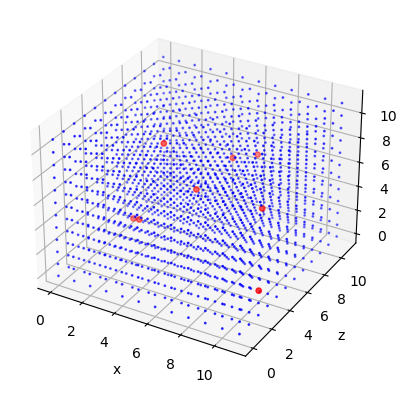

In [25]:
plot3D(np.arange(d.ncells[0]),np.arange(d.ncells[1]),np.arange(d.ncells[2]),xi, sz = sizes, clr = colors, save_file=False)

In [26]:
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")

Fraction of total elements active in the ROM: 0.46296296296296297%


### ROM Simulation

In [27]:
# Choose unknown parameter

params_rm = params[~np.isin(params,param_list)]
param_rom = random.choice(params_rm)

In [28]:
# Define the data-class

d_test = probdata(bc, mat_layout, src_layout, fdict, nref, L, param_rom, pb_dim=3)
FOS_test = Base_class_fem_heat_conduction(d_test,quad_deg)
ROM = FEM_solver_rom_ecsw(d_test, quad_deg)

In [29]:
# Initial guess

T_init_fos = np.zeros(FOS_test.n_nodes) + 2.
T_init_rom = np.transpose(V_sel)@T_init_fos # crucial to ensure the initial guess is contained in the reduced subspace

In [30]:
# Time taken to perform a FO simulation with the current parameter value

tic_fos = time.time()
NL_solution_p_fos_test, _, _, _, = solve_fos(FOS_test,T_init_fos)
toc_fos = time.time()

initial residual = 8079.874303895742 

iter 0, NL residual=90.98947141461974, delta=2.641653937311153
iter 1, NL residual=0.023837146074121008, delta=0.0005654350722311937
iter 2, NL residual=6.33522211204243e-09, delta=1.543071649831387e-07
Convergence !!!


In [31]:
# Time taken to simulate a ROM without hyper-reduction

tic_rom_woh = time.time()
NL_solution_p_reduced_woh = ROM.solve_rom(T_init_rom,np.ones_like(xi),V_sel)
toc_rom_woh = time.time()

initial residual = 7458.240635062873 



c:\Users\supar\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


iter 0, NL residual=73.43842226815724, delta=28.772669226103133
iter 1, NL residual=0.023211417809151206, delta=0.4308494662851837
iter 2, NL residual=5.144466299108868e-09, delta=0.00011542492542628045
Convergence !!!


In [32]:
# Time taken to simulate a ROM *with* hyper-reduction

tic_rom = time.time()
NL_solution_p_reduced = ROM.solve_rom(T_init_rom,xi,V_sel)
toc_rom = time.time()

initial residual = 0.003165384319024413 

iter 0, NL residual=5.2110750489225636e-05, delta=28.72488533954444
iter 1, NL residual=9.371194037645073e-09, delta=0.36600691370477545
Convergence !!!


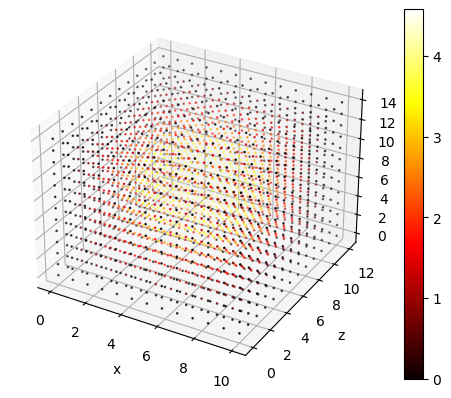

RMS_error is 0.006302997441614514 %


In [33]:
sol_red = V_sel@NL_solution_p_reduced.reshape(-1,1)  #+pca.mean_.reshape(-1,1)
plot3D(d_test.xi[0], d_test.xi[1], d_test.xi[2], sol_red,hmap=True)
print(f"RMS_error is {np.linalg.norm(sol_red-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")

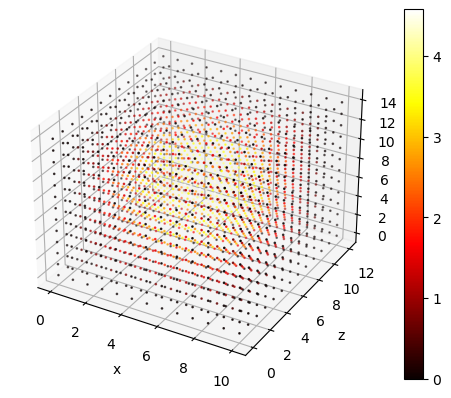



ROM Error without hyperreduction is 4.822551703168323e-08 %


In [34]:
plot3D(d_test.xi[0], d_test.xi[1], d_test.xi[2], NL_solution_p_fos_test,hmap=True)

print(f"\n\nROM Error without hyperreduction is {np.linalg.norm(V_sel@NL_solution_p_reduced_woh.reshape(-1,1)-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")

 
### Speedups

In [35]:
fos_sim_time = toc_fos - tic_fos
rom_sim_time_woh = toc_rom_woh - tic_rom_woh
rom_sim_time = toc_rom - tic_rom

In [36]:
print(f"speedup without hyperreduction:{fos_sim_time/rom_sim_time_woh}")
print(f"speedup with hyperreduction:{fos_sim_time/(rom_sim_time)}")
# h_total_setup_time = (toc_h_setup_b+toc_h_setup_a) - (tic_h_setup_b+tic_h_setup_a) #this is one time

speedup without hyperreduction:1.0042087314381656
speedup with hyperreduction:187.5209505864067
